In [219]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import pandas.tseries.holiday as pd_holiday

In [220]:
ticker = 'TSLA'
start_date = '2023-11-01'  # Fetch data from this date
end_date = '2024-12-01'

In [221]:
tesla_data = yf.download(ticker, start=start_date, end=end_date)
close_prices = tesla_data['Close']

[*********************100%***********************]  1 of 1 completed


In [222]:
tesla_data = tesla_data.asfreq('B')  # Business day frequency (no weekends)
close_prices = tesla_data['Close'].dropna()

In [223]:
short_window = 5 
long_window = 10 

In [224]:
tesla_data['Short_MA'] = close_prices.rolling(window=short_window).mean()
tesla_data['Long_MA'] = close_prices.rolling(window=long_window).mean()

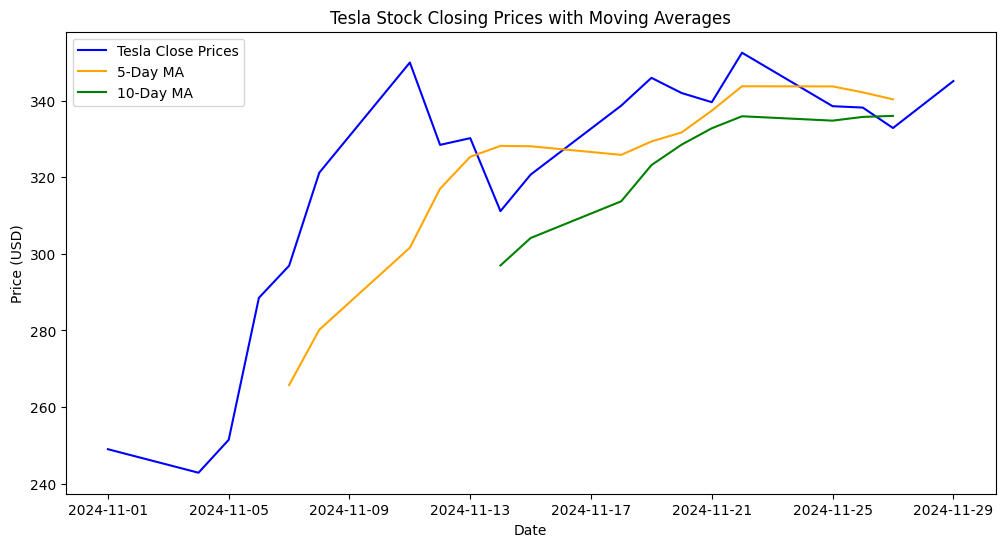

In [225]:
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Tesla Close Prices', color='blue')
plt.plot(tesla_data['Short_MA'], label=f'{short_window}-Day MA', color='orange')
plt.plot(tesla_data['Long_MA'], label=f'{long_window}-Day MA', color='green')
plt.title('Tesla Stock Closing Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [226]:
def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary.")


In [227]:
def difference_once(series):
    diff_series = series.diff().dropna()
    return diff_series

In [228]:
close_prices_stationary = difference_once(close_prices)

In [229]:
print("\nStationarity Check after First Differencing:")
check_stationarity(close_prices_stationary)


Stationarity Check after First Differencing:
ADF Statistic: -2.521865406818086
p-value: 0.1102444675576279
Data is not stationary.


In [230]:
close_prices_stationary = difference_once(close_prices_stationary)

In [231]:

check_stationarity(close_prices_stationary)

ADF Statistic: -4.068450459317749
p-value: 0.001091588544413464
Data is stationary.


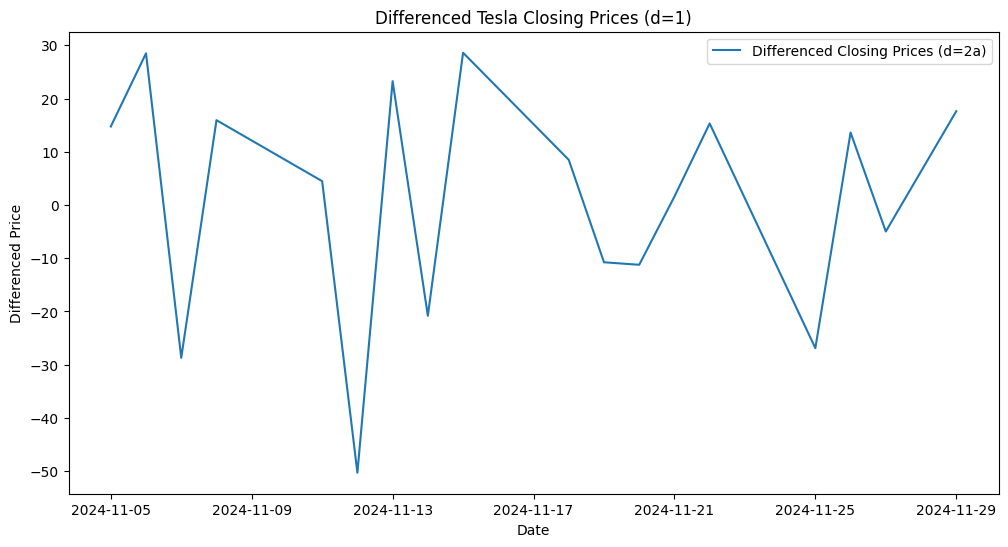

In [232]:
plt.figure(figsize=(12, 6))
plt.plot(close_prices_stationary, label='Differenced Closing Prices (d=2a)')
plt.title('Differenced Tesla Closing Prices (d=1)')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

In [233]:
lags = min(20, len(close_prices_stationary) - 1) 

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

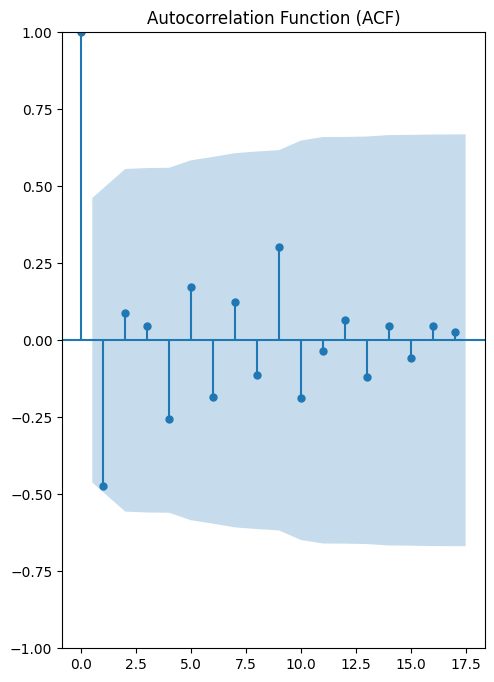

In [234]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plot_acf(close_prices_stationary, lags=lags, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

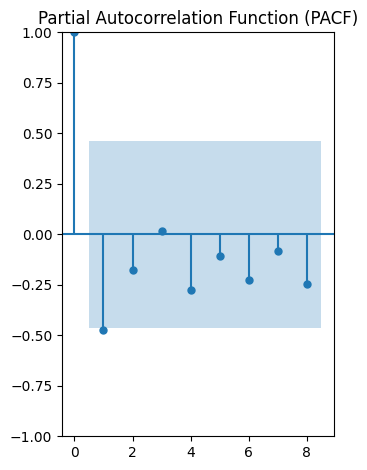

In [235]:
plt.subplot(122)
plot_pacf(close_prices_stationary, lags=8, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

In [262]:
model = ARIMA(close_prices, order=(0, 2, 1))
model_fit = model.fit()

f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [263]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                   20
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -76.377
Date:                Sat, 14 Dec 2024   AIC                            156.754
Time:                        17:07:14   BIC                            158.534
Sample:                             0   HQIC                           156.999
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9147      0.369     -2.479      0.013      -1.638      -0.191
sigma2       257.2343    111.980      2.297      0.022      37.757     476.711
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [264]:
forecast_days = 10  # Predict next 40 days
forecast = model_fit.forecast(steps=forecast_days)
forecast_dates = pd.date_range(start=tesla_data.index[-1], periods=forecast_days + 30, freq='B')
forecast_dates = [date for date in forecast_dates if date not in pd_holiday.USFederalHolidayCalendar().holidays()][:forecast_days]


f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


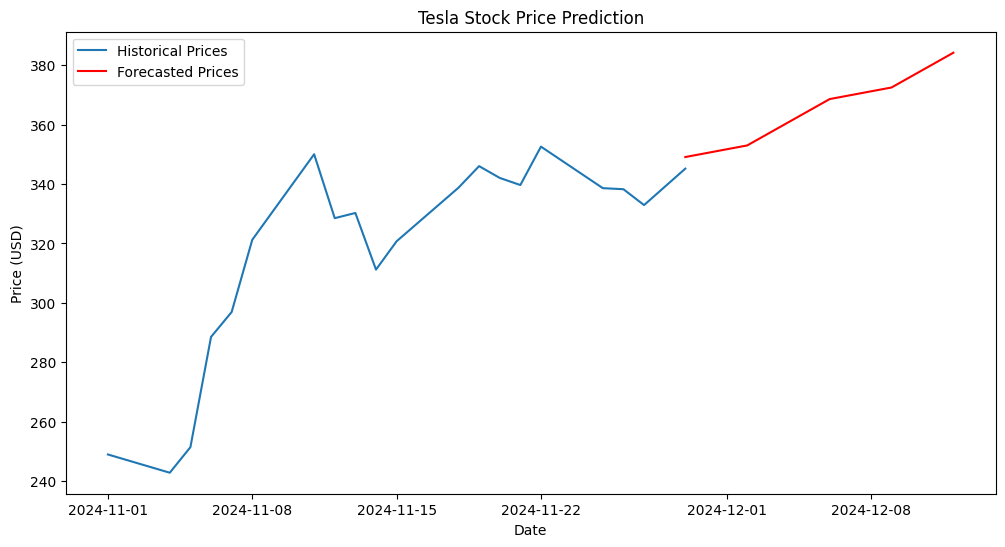

In [265]:
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Historical Prices')
plt.plot(forecast_dates, forecast, color='red', label='Forecasted Prices')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [266]:
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Price': forecast})
print(forecast_df)

         Date  Predicted Price
20 2024-11-29       349.059815
21 2024-12-02       352.959626
22 2024-12-03       356.859436
23 2024-12-04       360.759247
24 2024-12-05       364.659058
25 2024-12-06       368.558869
26 2024-12-09       372.458680
27 2024-12-10       376.358491
28 2024-12-11       380.258302
29 2024-12-12       384.158113


In [241]:
forecast_df.to_csv('tesla_forecasted_prices.csv', index=False)
print("Forecasted data saved to 'tesla_forecasted_prices.csv'")

Forecasted data saved to 'tesla_forecasted_prices.csv'
